This notebook demostrates how to read out the FFT frames, this may be useful if you dont want to use the GGRX GUI.

In [38]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import SoapySDR
from SoapySDR import *  # SOAPY_SDR_ constants
import sys
from skimage.exposure import exposure

def plot_spectrogram(im):
    """ Uses rescaling to improve the dynamics. """
    im = np.array(im)
    p2, p98 = np.percentile(im, (1, 99))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))
    
    plt.figure(figsize = (9.75, 10))
    plt.xlabel('Bandwidth (MHz)')
    xt = np.linspace(0, im.shape[1], 9, endpoint=True)
    plt.xticks(xt, [f'{-40 + i * 10:.2f}' for i in range(len(xt))])
    
    plt.imshow(im, interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.grid()
    plt.show()
    
def plot_fft(fft_frame):
    """ Plot single frame from the spectrogram. """
    
    plt.figure(figsize = (9.75, 5))
    
    plt.ylabel('Magnitude (dB)')
    plt.xlabel('Bandwidth (MHz)')
    xt = np.linspace(0, fft_frame.shape, 9, endpoint=True)
    plt.xticks(xt, [f'{-40 + i * 10:.2f}' for i in range(len(xt))])
    
    plt.plot(fft_frame)
    plt.tight_layout()
    plt.grid()
    plt.show()

# Start the local SoapySDR server
This handles programming the FPGA image if needed.

**Note:** You can kill the server with "docker kill spectrogram_server"

In [2]:
! spectrogram --server_only

INFO:main:Pulling latest docker image...
Using default tag: latest
latest: Pulling from gasparka/spectrogram
Digest: sha256:8b85e91c4605ae1cd9ae7fcbd3b1de8ff8a25bdb2fffc8d9eaf0ef4eff4a2f2a
Status: Image is up to date for gasparka/spectrogram:latest
INFO:main:Probing for LimeSDR-Mini devices...
INFO:main:remote_available=True, local_available=True, local_fpga_ok=True
INFO:main:Starting server daemon...
3c9d93a6e45056aff0c3fbe4afb639289631795162ba0c27e4fdc5271bf415cf
INFO:main:Server is started!


# Connect to the server

In [3]:
sample_rate = 80e6 # Known to work in range 40e6 - 80e6
center_frequency_mhz = 2440e6

sdr_device = SoapySDR.Device({'driver': 'remote', 'cacheCalibrations': '1'}) 
sdr_device.setAntenna(SOAPY_SDR_RX, 0, 'Auto')
sdr_device.setSampleRate(SOAPY_SDR_RX, 0, sample_rate)
sdr_device.setBandwidth(SOAPY_SDR_RX, 0, sample_rate)
sdr_device.setDCOffsetMode(SOAPY_SDR_RX, 0, True)
sdr_device.setFrequency(SOAPY_SDR_RX, 0, center_frequency_mhz)

gains = {"LNA": 0, "TIA": 0, "PGA": -12}
for gain, value in gains.items():
    sdr_device.setGain(SOAPY_SDR_RX, 0, gain, value)

rx_stream = sdr_device.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CS16, [0],
                    {'remote:mtu': '2120', 'remote:prot': 'tcp'})

# Plot some FFT frames

<IPython.core.display.Javascript object>


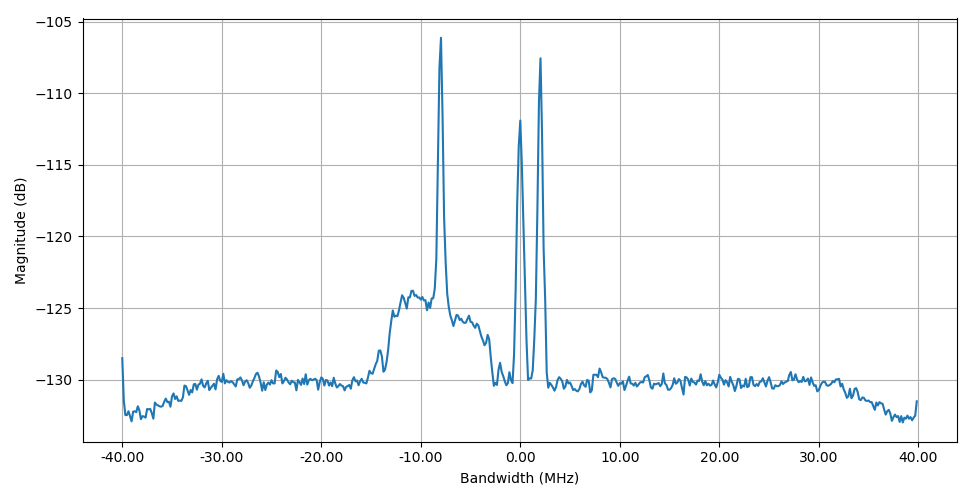

<IPython.core.display.Javascript object>


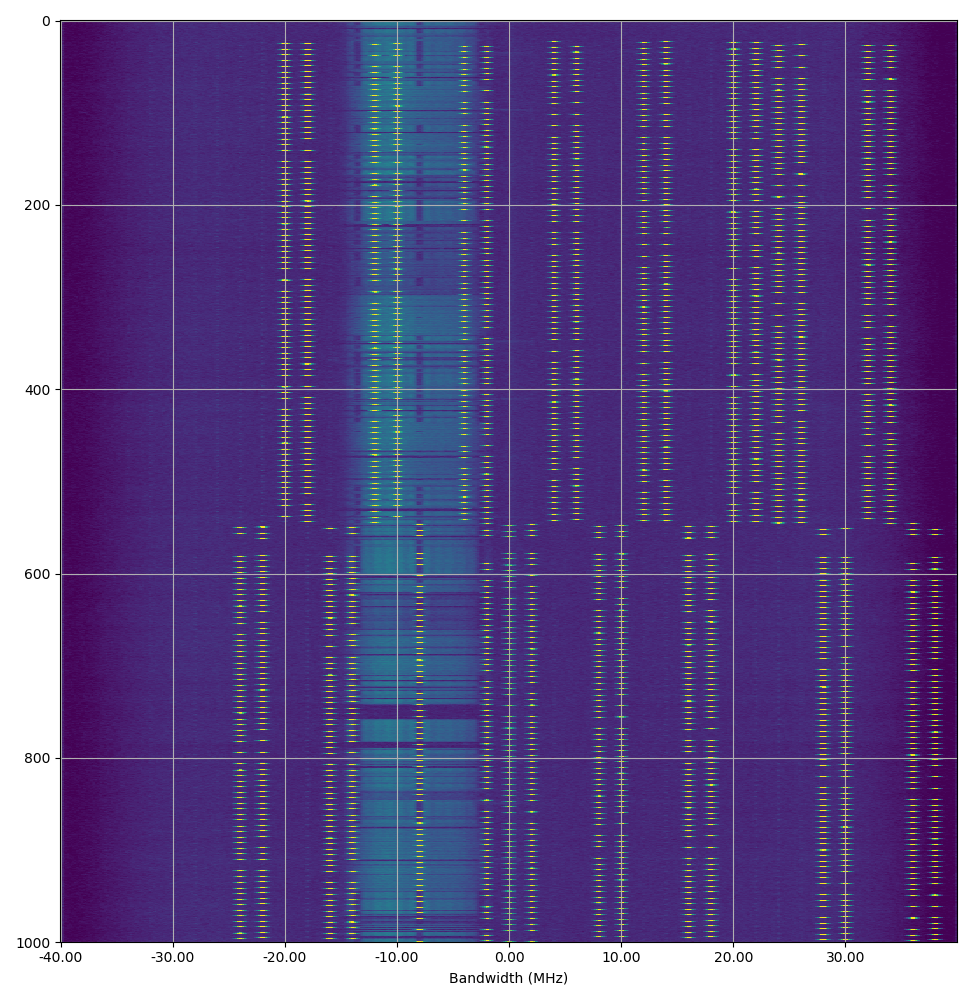

In [44]:
frames = 1000
rx_buff = np.empty(shape=(frames, 512), dtype=np.int32)
sdr_device.activateStream(rx_stream)
for i in range(frames):
    sr = sdr_device.readStream(rx_stream, [rx_buff[i]], 512, timeoutUs=1000000)
    if sr.ret != 512:
        print(sr.ret, i)
        print('Bad samples from remote!')

sdr_device.deactivateStream(rx_stream)

# mult by 2**-43 compensates for the fixed-point format coming from FPGA
# -24 compensates for the 256x average pooling
result = np.log10(rx_buff.astype(float) * 2**-43) * 10 - 24

plot_fft(result[-1])
plot_spectrogram(result)